In [1]:
import pandas as pd
import numpy as np
import os, warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [2]:
# preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# model
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

# evaluation
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# metric
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_csv('../data/clean_data.csv')

In [4]:
df.isna().sum()[df.isna().sum() > 0]

numberof_floors       6
energystar_score    799
dtype: int64

In [5]:
def data_selection(data:pd.DataFrame, target:str, skip_features:list, stratify:str=None, test_size:float=.2, random_state:int=0):
    
    X = data.drop(columns = [target] + skip_features)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test

In [24]:
def model_selection(data:pd.DataFrame, target:str, skip_features:list, preprocessing_pipeline, models_dict:dict, preprocessing_param_grid:dict, cv_n_splits:int=5, stratify:str=None, test_size:float=.2, random_state:int=0, chart:bool=True, verbosity:int=0):
        
    X_train, X_test, y_train, y_test = data_selection(data, target, skip_features, stratify, test_size, random_state)
    
    cv = KFold(n_splits=cv_n_splits, shuffle = True, random_state=0)
    
    result_df = pd.DataFrame(columns = models_dict.keys())
    
    for key, values in models_dict.items():
                
        model = values.get('model')
        model_param_grid=values.get('param_grid')
        param_grid = dict(list(preprocessing_param_grid.items()) + list(model_param_grid.items()))
        pipe=Pipeline((('preprocessing', preprocessing), ('model', model)))
        
        locals()[key] = GridSearchCV(pipe, param_grid, cv=cv, scoring='neg_root_mean_squared_error', verbose=verbosity)
        locals()[key].fit(X_train, y_train)
        y_pred=locals()[key].best_estimator_.predict(X_test)
        rmse=mean_squared_error(y_test, y_pred, squared=False)
        r2=r2_score(y_test, y_pred)
        
        result_df.loc['rmse', key] = rmse
        result_df.loc['r2', key] = r2
        
        for param in locals()[key].best_params_:
            result_df.loc[param, key] = locals()[key].best_params_[param]
        
        if chart:
            fig, ax = plt.subplots()
            ax.scatter(y_test, y_pred, marker='.')
            ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
            ax.set_xlabel('Measured')
            ax.set_ylabel('Predicted')
            plt.title(key)
            plt.show()
        
    display(result_df)
    
    return locals()[result_df.loc['rmse'].astype(float).idxmin()]

In [7]:
seed = 42

## GHG emissions model

In [8]:
df_ghg_emissions = df[df.ghg_emissions > 0]
df_ghg_emissions['ghg_emissions_log'] = np.log(df.ghg_emissions)

### Test 1

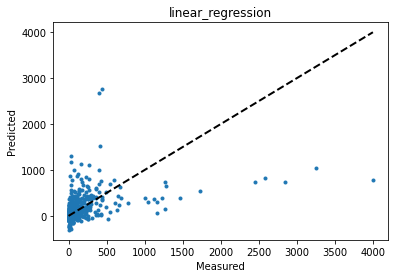

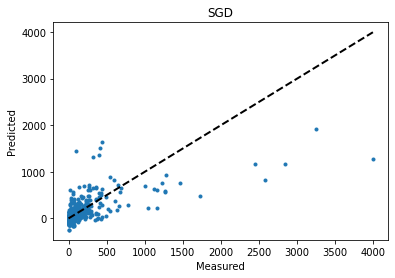

,linear_regression,SGD
rmse,379.018,280.485
r2,-0.0630828,0.417808
preprocessing__num_preprocessing__normalizer,FunctionTransformer(func=<function <lambda> at...,passthrough
preprocessing__num_preprocessing__scaler,StandardScaler(),MinMaxScaler()
preprocessing__remainder,drop,passthrough


In [9]:
target='ghg_emissions'
skip_features=['site_energy_use_wn', 'energystar_score', 'ghg_emissions_log']

num_features = df.columns[~df.columns.str.contains('cat_')]
num_features = num_features[~np.isin(num_features, [target]+skip_features)].tolist()

num_preprocessing = Pipeline((
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)), 
    ('normalizer', 'passthrough'),
    ('scaler', 'passthrough')
), verbose = False)

preprocessing = ColumnTransformer([('num_preprocessing', num_preprocessing, num_features)])
pipe=Pipeline((('preprocessing', preprocessing), ('model', LinearRegression())))


preprocessing_param_grid = {
    'preprocessing__remainder': ['passthrough', 'drop'],
    'preprocessing__num_preprocessing__normalizer': ['passthrough', FunctionTransformer(lambda x: np.log(np.abs(x)+1))],
    'preprocessing__num_preprocessing__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()]
}

models_dict = {
    'linear_regression': {
        'model': LinearRegression(),
        'param_grid': {},
    },
    'SGD': {
        'model': SGDRegressor(),
        'param_grid': {},
    }
}

model_selection(
    df_ghg_emissions, 
    target=target, 
    skip_features=skip_features,
    preprocessing_pipeline=preprocessing,
    models_dict=models_dict,
    preprocessing_param_grid=preprocessing_param_grid,
    random_state=seed
)

### Test 2 : log target

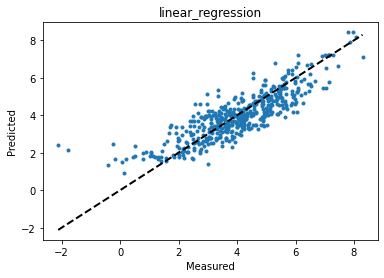

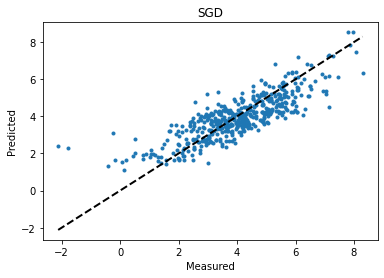

,linear_regression,SGD
rmse,0.805671,0.851602
r2,0.716174,0.68289
preprocessing__num_preprocessing__normalizer,FunctionTransformer(func=<function <lambda> at...,FunctionTransformer(func=<function <lambda> at...
preprocessing__num_preprocessing__scaler,RobustScaler(),RobustScaler()
preprocessing__remainder,passthrough,passthrough


In [10]:
target='ghg_emissions_log'
skip_features=['site_energy_use_wn', 'energystar_score', 'ghg_emissions']

num_features = df.columns[~df.columns.str.contains('cat_')]
num_features = num_features[~np.isin(num_features, [target]+skip_features)].tolist()

num_preprocessing = Pipeline((
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)), 
    ('normalizer', 'passthrough'),
    ('scaler', 'passthrough')
), verbose = False)

preprocessing = ColumnTransformer([('num_preprocessing', num_preprocessing, num_features)])
pipe=Pipeline((('preprocessing', preprocessing), ('model', LinearRegression())))


preprocessing_param_grid = {
    'preprocessing__remainder': ['passthrough', 'drop'],
    'preprocessing__num_preprocessing__normalizer': ['passthrough', FunctionTransformer(lambda x: np.log(np.abs(x)+1))],
    'preprocessing__num_preprocessing__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()]
}

models_dict = {
    'linear_regression': {
        'model': LinearRegression(),
        'param_grid': {},
    },
    'SGD': {
        'model': SGDRegressor(random_state = seed),
        'param_grid': {},
    }
}

model_selection(
    df_ghg_emissions, 
    target=target, 
    skip_features=skip_features,
    preprocessing_pipeline=preprocessing,
    models_dict=models_dict,
    preprocessing_param_grid=preprocessing_param_grid,
    random_state=seed
)

### Test 2 : more models

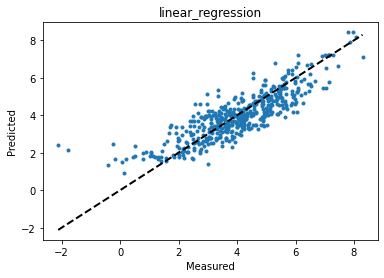

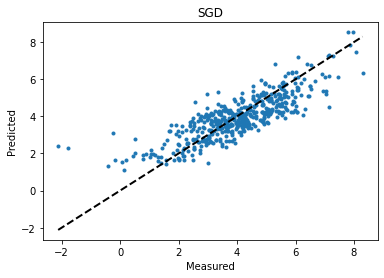

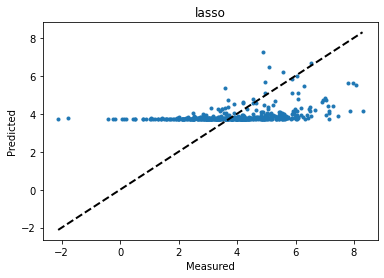

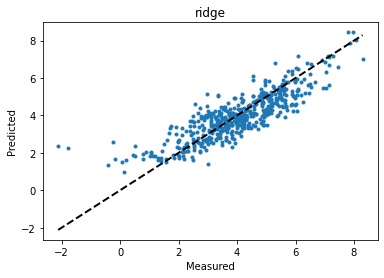

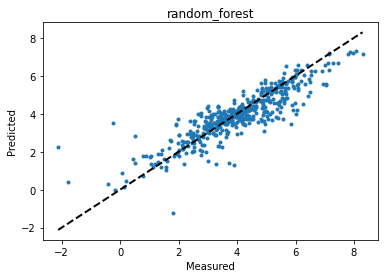

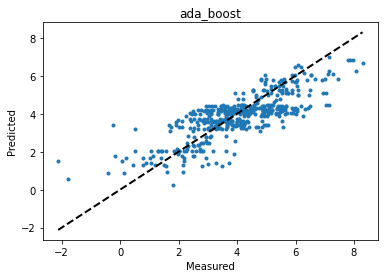

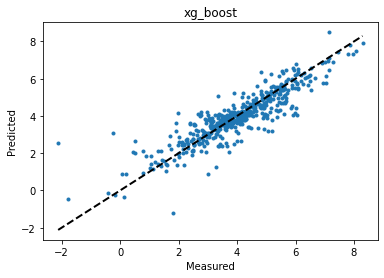

,linear_regression,SGD,lasso,ridge,random_forest,ada_boost,xg_boost
rmse,0.805671,0.851602,1.41898,0.804392,0.723336,0.924396,0.693242
r2,0.716174,0.68289,0.119575,0.717074,0.771221,0.62636,0.789861
preprocessing__num_preprocessing__normalizer,FunctionTransformer(func=<function <lambda> at...,FunctionTransformer(func=<function <lambda> at...,passthrough,FunctionTransformer(func=<function <lambda> at...,FunctionTransformer(func=<function <lambda> at...,passthrough,FunctionTransformer(func=<function <lambda> at...
preprocessing__num_preprocessing__scaler,RobustScaler(),RobustScaler(),RobustScaler(),StandardScaler(),StandardScaler(),StandardScaler(),RobustScaler()
preprocessing__remainder,passthrough,passthrough,passthrough,passthrough,passthrough,passthrough,passthrough


In [11]:
models_dict = {
    'linear_regression': {
        'model': LinearRegression(),
        'param_grid': {},
    },
    'SGD': {
        'model': SGDRegressor(random_state = seed),
        'param_grid': {},
    },
    'lasso': {
        'model': Lasso(random_state = seed),
        'param_grid': {},
    },
    'ridge': {
        'model': Ridge(random_state = seed),
        'param_grid': {},
    },
    'random_forest': {
        'model': RandomForestRegressor(random_state = seed),
        'param_grid': {},
    },
    'ada_boost': {
        'model': AdaBoostRegressor(random_state = seed),
        'param_grid': {},
    },
    'xg_boost': {
    'model': XGBRegressor(random_state = seed),
    'param_grid': {},
    },
}

model_selection(
    df_ghg_emissions, 
    target=target, 
    skip_features=skip_features,
    preprocessing_pipeline=preprocessing,
    models_dict=models_dict,
    preprocessing_param_grid=preprocessing_param_grid,
    random_state=seed
)

### Test 5: Xgboost finetuning

In [22]:
models_dict = {
    'xg_boost': {
    'model': XGBRegressor(random_state = seed),
    'param_grid': {
        'model__learning_rate': [0.01,0.1,0.5,0.9],
        'model__n_estimators' : [100, 200],
        'model__subsample' : [0.3,0.5,0.9],
        'model__max_depth': [2, 3, 4, 5],
        'model__verbosity': [0]
    },
}}

In [23]:
%%time
model_selection(
    df_ghg_emissions, 
    target=target, 
    skip_features=skip_features,
    preprocessing_pipeline=preprocessing,
    models_dict=models_dict,
    preprocessing_param_grid=preprocessing_param_grid,
    random_state=seed,
    chart=False
)

,xg_boost
rmse,0.685752
r2,0.794377
model__learning_rate,0.1
model__max_depth,5
model__n_estimators,200
model__subsample,0.9
model__verbosity,0
preprocessing__num_preprocessing__normalizer,FunctionTransformer(func=<function <lambda> at...
preprocessing__num_preprocessing__scaler,StandardScaler()
preprocessing__remainder,passthrough


CPU times: user 1h 47min 4s, sys: 2min 57s, total: 1h 50min 2s
Wall time: 39min 34s
